In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from cityscapesscripts.helpers import labels

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from data_loader.cityscapes import CityscapesDataset
import utils.transforms
import torchvision.transforms as transforms
from model.deeplabv3plus import DeepLabv3Plus
from model.metric import iou

In [8]:
checkpoint_file = os.path.join('./checkpoints', 'best_model.pt')
img_root = './data/leftImg8bit'
mask_root = './data/gtFine'
transform = utils.transforms.Compose(
    [utils.transforms.Resize((512, 512)), utils.transforms.ToTensor()]
)

train_set = CityscapesDataset("train", img_root, mask_root, transform=transform)
val_set = CityscapesDataset("val", img_root, mask_root, transform=transform)

batch_size = 4
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 20  # 0 -> 19
ignore_idx = train_set.ignoreId  # ignore 19
learning_rate = 0.001

model = DeepLabv3Plus(num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=ignore_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

checkpoint = torch.load(checkpoint_file)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [9]:
def get_palette():
    """
    Palette sequence used for the Cityscapes annotations.

    From PIL documentation:
    Palette sequence must contain 768 integer values, where each group
    of three values represent the red, green, and blue values for the
    corresponding pixel index.
    """
    palette = []
    trainId_to_color = {label.trainId: label.color for label in labels.labels}
    for i in range(19):
        palette.extend(trainId_to_color[i])
    zero_pads = [0] * (768 - len(palette))
    palette.extend(zero_pads)
    return palette


def color_mask(mask, palette):
    mask = Image.fromarray(mask.astype(np.uint8))
    mask.putpalette(palette)
    return mask


palette = get_palette()

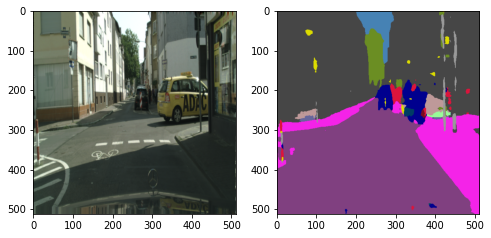

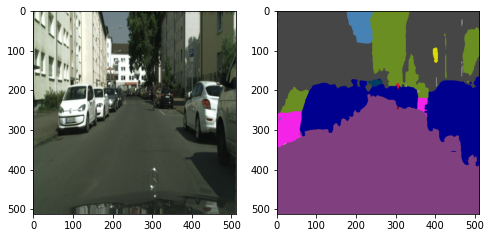

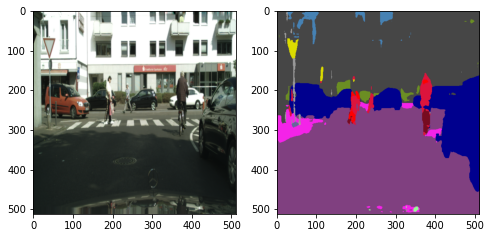

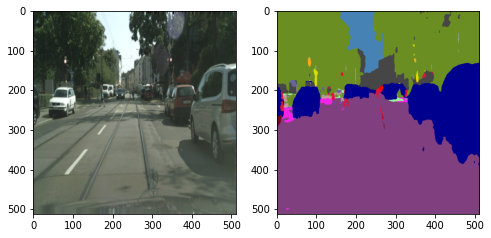

In [18]:
toPIL = transforms.ToPILImage()
for i, sample in enumerate(val_loader):
    if i == 1:
        break

    with torch.no_grad():
        images, masks = sample["image"].to(device), sample["mask"].to(device)
        
        pred = model(images)
        pred = torch.argmax(pred, dim=1).cpu().detach()
        
        for i in range(len(images)):
            image = toPIL(images[i])
            mask = color_mask(pred[i].numpy(), palette)
            fig, ax = plt.subplots(1, 2, figsize=(8, 8))
            ax[0].imshow(image)
            ax[1].imshow(mask)
            plt.show()